# MODEL GRIDS WITH PYCLOUDY

## Global Budget (see previous notebook)

## The upper envelope of HII regions in the BPT diagram

### Build a grid of plane-parallel photoionization models with open geometry, density nH= 100 cm$^{-3}$, no dust, varying log U between -4.5 and -1.5 by steps of 0.5 dex, for the metallicities Z = 0.001, 0.002, 0.008, 0.02, 0.040 taking as ionization source the starburst99 models (Kroupa IMF, Geneva high metallicity tracks, Pauldrach/Hillier atmospheres) at an age of 1 Myr for the corresponding metallicities.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyCloudy as pc
pc.config.cloudy_exe = 'cloudy.exe'
models_dir = '../../Models/'

The Starburst code is available from http://www.stsci.edu/science/starburst99/docs/default.htm

Download the files named ISB_*.ascii from https://github.com/Morisset/NEBULATOM-tools/tree/master/Starburst99

##### We transform these files into Cloudy SED .mod file.

In [2]:
! cd ../Starburst99/ ; ls *.stb99

ISB_001.stb99 ISB_004.stb99 ISB_008.stb99 ISB_020.stb99 ISB_040.stb99


In [3]:
! cd ../Starburst99/ ; echo 'compile star "ISB_008.stb99"' | cloudy.exe


                               This is a beta release of Cloudy, and is intended for testing only.
Please help make Cloudy better by posing problems or suggestions on http://tech.groups.yahoo.com/group/cloudy_simulations/.

                                                Cloudy 17.00 beta 1 (prerelease)
                                                         www.nublado.org

                       **************************************17Jan01**************************************
                       *                                                                                 *
                       * compile star "ISB_008.stb99"                                                    *
 Creating ISB_008.ascii....
 GridCompile on the job.
 lgCompileAtmosphere got ISB_008.ascii.
 lgCompileAtmosphere completed ok.


 The compilation was successful!

 Good Luck!!


 [Stop in ParseCompile at parse_compile.cpp:491, Cloudy exited OK]


##### We check that the ISB_008.mod file has been created.

In [4]:
!ls -latr ../Starburst99/ISB_008*

-rw-------  1 christophemorisset  staff  476398 Apr 14 13:05 ../Starburst99/ISB_008.stb99
-rw-------  1 christophemorisset  staff  230772 May 18 17:32 ../Starburst99/ISB_008.mod
-rw-------  1 christophemorisset  staff  104437 May 18 17:32 ../Starburst99/ISB_008.ascii


##### We ask Cloudy for the availabel values of the parameters.

In [5]:
! cd ../Starburst99/ ; echo 'table star "ISB_008.mod" list' | cloudy.exe


                               This is a beta release of Cloudy, and is intended for testing only.
Please help make Cloudy better by posing problems or suggestions on http://tech.groups.yahoo.com/group/cloudy_simulations/.

                                                Cloudy 17.00 beta 1 (prerelease)
                                                         www.nublado.org

                       **************************************17Jan01**************************************
                       *                                                                                 *
                       * table star "ISB_008.mod" list                                                   *

          Age |
--------------|----------
        10000 |         1
      1010000 |         2
      2010000 |         3
      3010000 |         4
      4010000 |         5
      5010000 |         6

 [Stop in InitIndexArrays at stars.cpp:4029, Cloudy exited OK]


We have to repeat the previous procedure with the 0.001, 0.004, 0.020, and 0.040 metallicities. 

In [6]:
! cd ../Starburst99/ ; echo 'compile star "ISB_001.stb99"' | /usr/local/Cloudy/c17.00_rc1/source/cloudy.exe
! cd ../Starburst99/ ; echo 'compile star "ISB_004.stb99"' | /usr/local/Cloudy/c17.00_rc1/source/cloudy.exe
! cd ../Starburst99/ ; echo 'compile star "ISB_020.stb99"' | /usr/local/Cloudy/c17.00_rc1/source/cloudy.exe
! cd ../Starburst99/ ; echo 'compile star "ISB_040.stb99"' | /usr/local/Cloudy/c17.00_rc1/source/cloudy.exe
! ls ../Starburst99/ISB*.mod


                               This is a beta release of Cloudy, and is intended for testing only.
Please help make Cloudy better by posing problems or suggestions on http://tech.groups.yahoo.com/group/cloudy_simulations/.

                                                Cloudy 17.00 beta 1 (prerelease)
                                                         www.nublado.org

                       **************************************17Jan01**************************************
                       *                                                                                 *
                       * compile star "ISB_001.stb99"                                                    *
 Creating ISB_001.ascii....
 GridCompile on the job.
 lgCompileAtmosphere got ISB_001.ascii.
 lgCompileAtmosphere completed ok.


 The compilation was successful!

 Good Luck!!


 [Stop in ParseCompile at parse_compile.cpp:491, Cloudy exited OK]

                               This is a beta releas

### Move the five ISB*.mod files to the directory where the models are run.


In [7]:
!mv ../Starburst99/*.mod ../../Models

##### We define a function to manage the models.

In [80]:
options = ('no molecules',
           'no level2 lines',
           'no fine opacities',
           'atom h-like levels small',
           'atom he-like levels small',
           'element limit off -7',
            )

from pyCloudy.utils.physics import abund_Asplund_2009

def make_mod(name, logU, Z_str, grains=False, NoO_law=False):
    assert Z_str in ('0.001', '0.004', '0.008', '0.020', '0.040')
    Z = np.float(Z_str)
    NH = 100
    ff = 1.0
    abund = abund_Asplund_2009.copy()    
    delta_O = np.log10(Z/0.020)
    for elem in abund:
        if elem != 'He':
            abund[elem] += delta_O
    if NoO_law:
        X = 12 + abund['O']
        if X < 8:
            abund['N'] = abund['O'] - 1.6
        else:        
            abund['N'] = abund['O'] + 1.6 * (X - 8) - 1.6
    c_input = pc.CloudyInput('{0}/{1}'.format(models_dir, name))
    c_input.set_star(SED='table star "ISB_{}.mod"'.format(Z_str.split('.')[1]), 
                     SED_params=(1e6),
                     lumi_unit = 'ionization parameter', lumi_value = logU)
    c_input.set_cste_density(np.log10(NH), ff = ff)
    c_input.set_abund(ab_dict = abund)
    c_input.set_iterate(1)
    if grains:
        c_input.set_grains('Orion {}'.format(10**delta_O))
    c_input.set_distance(dist=1., unit='kpc', linear=True)
    c_input.set_other(options)
    c_input.set_stop(('temperature off', 'pfrac 0.02'))
    c_input.set_emis_tab(['H  1  4861.36A', 'H  1  6562.85A', 
                          'N  2  6583.45A', 'O  3  5006.84A'])
    c_input.print_input()

In [8]:
generic_name = 'M72_'

In [82]:
for logU in np.arange(-4.5, -1.49, 0.5):
    for Z in ('0.001', '0.004', '0.008', '0.020', '0.040'):
        # making 35 models
        name = '{}{:.1f}_{}'.format(generic_name, logU, Z)
        make_mod(name, logU, Z, grains=True)

In [83]:
pc.run_cloudy(dir_=models_dir, n_proc=7, model_name=generic_name)

In [66]:
#generic_name = 'M73_'

In [67]:
#for logU in np.arange(-4.5, -1.49, 0.5):
#    for Z in ('0.001', '0.004', '0.008', '0.020', '0.040'):
#        # making 35 models
#        name = '{}{:.1f}_{}'.format(generic_name, logU, Z)
#        make_mod(name, logU, Z, grains=True, NoO_law=True)

In [68]:
#pc.run_cloudy(dir_=models_dir, n_proc=7, model_name=generic_name)

##### We read the results into a list.

In [9]:
Ms = pc.load_models('{}/{}'.format(models_dir, generic_name))

In [92]:
print([M.n_zones for M in Ms])
for M in Ms:
    print('{:.2f} {:.2f}'.format(M.abund['O'], M.log_U_mean))

[219, 215, 220, 231, 239, 198, 199, 204, 209, 217, 175, 172, 176, 189, 189, 146, 143, 152, 169, 170, 127, 126, 136, 155, 157, 117, 117, 130, 150, 155, 112, 112, 124, 146, 145]
-4.61 -1.50
-4.01 -1.50
-3.71 -1.50
-3.31 -1.50
-3.01 -1.50
-4.61 -2.00
-4.01 -2.00
-3.71 -2.00
-3.31 -2.00
-3.01 -2.00
-4.61 -2.50
-4.01 -2.50
-3.71 -2.50
-3.31 -2.50
-3.01 -2.50
-4.61 -3.00
-4.01 -3.00
-3.71 -3.00
-3.31 -3.00
-3.01 -3.00
-4.61 -3.50
-4.01 -3.50
-3.71 -3.50
-3.31 -3.50
-3.01 -3.50
-4.61 -4.00
-4.01 -4.00
-3.71 -4.00
-3.31 -4.00
-3.01 -4.00
-4.61 -4.50
-4.01 -4.50
-3.71 -4.50
-3.31 -4.50
-3.01 -4.50


In [10]:
plt.scatter([M.abund['O'] for M in MsD], [M.abund['N']-M.abund['O'] for M in Ms])

NameError: name 'MsD' is not defined

In [73]:
### Plot the observational BPT diagram (log [O III] $\lambda$ 5007/H$\beta$, vs log [N II] $\lambda$ 6584/H$\alpha$) for a set of emission line galaxies from the Sloan Digital Sky Survey. The relevant line intensities are given in file BPT4Graz_f4.dat from the  https://github.com/Morisset/NEBULATOM-tools/tree/master/Data site.

##### We read the observations into the obs variable.

In [11]:
obs = np.genfromtxt('../Data/BPT4Graz_f4.dat', names=True)

##### We check that the observations correspond to what we expect.

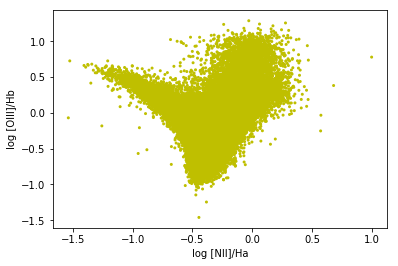

In [12]:
f, ax = plt.subplots()
ax.scatter(obs['xN2Ha'], obs['yO3Hb'], edgecolor='none', color='y', 
           marker='.')
ax.set_xlabel('log [NII]/Ha')
ax.set_ylabel('log [OIII]/Hb')

In [13]:
Ms[0].emis_labels

array(['H__1_486136A', 'H__1_656285A', 'N__2_658345A', 'O__3_500684A'], 
      dtype='<U12')

### Overplot the grid of photoionization models, joining models with same metallicities by dashed lines and models with same ionization parameter by continuous lines and comment on the resulting plot.

(-2.5, 1.5)

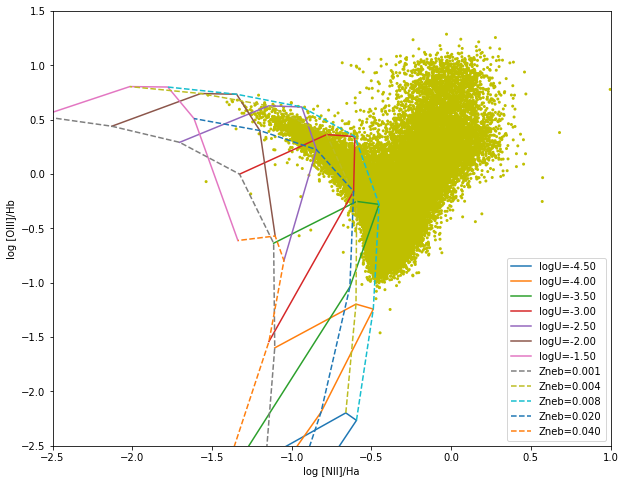

In [14]:
f, ax = plt.subplots(figsize=(10,8))
ax.scatter(obs['xN2Ha'], obs['yO3Hb'], edgecolor='none', color='y', 
           marker='.')
ax.set_xlabel('log [NII]/Ha')
ax.set_ylabel('log [OIII]/Hb')

# A small function to extract a line intensity from all the models 
extract_line = lambda label:np.array([M.get_emis_vol(label) for M in Ms])
    
Ha = extract_line('H__1_656285A')
Hb = extract_line('H__1_486136A')
O3 = extract_line('O__3_500684A')
N2 = extract_line('N__2_658345A')

# Recover the list of unique values of the input parameters from the name of the model:
Z = np.array([float(M.model_name_s.split('_')[2]) for M in Ms])
Z_u = np.sort(np.unique(Z))
logU = np.array([float(M.model_name_s.split('_')[1]) for M in Ms])
logU_u = np.sort(np.unique(logU))
    
for logU1 in logU_u:
    s = np.where(logU == logU1)[0] # find the indices where logU is the current logU1
    indx = s[Z[s].argsort()] #find and sort the indices of the models with the 
    ax.plot(np.log10(N2/Ha)[indx], np.log10(O3/Hb)[indx], linestyle='-', label = 'logU={0:.2f}'.format(logU1))
for Z1 in Z_u:
    s = np.where(Z == Z1)[0] # 
    indx = s[logU[s].argsort()]
    ax.plot(np.log10(N2/Ha)[indx], np.log10(O3/Hb)[indx], linestyle='--', label = 'Zneb={0:.3f}'.format(Z1))
ax.legend(loc=4)
    
ax.set_xlim((-2.5, 1))
ax.set_ylim((-2.5, 1.5))


### ??? Comment on your results with respect to the upper envelopes of Kewley et al. (2001), Stasinska et al. (2006), and Dopita et al. (2013).

### Find in the 3MdB data base from the ‘HII CHIM’ grid and plot them in a similar diagram. https://sites.google.com/site/mexicanmillionmodels/

In [17]:
import pymysql
import pandas as pd 

##### We connect to the database.

In [25]:
co = pymysql.connect(host='132.248.1.102', db='3MdB', user='OVN_user', passwd='oiii5007')

##### We send the request to the database. 

In [28]:
res = pd.read_sql("""SELECT H__1__4861A, H__1__6563A, O__3__5007A, N__2__6584A, logU_mean, oxygen 
FROM tab 
WHERE ref = 'HII_CHIm'
""", con=co)

##### We can now close the connection to the database.

In [29]:
co.close()

In [30]:
N = len(res)
print(N)

7854


##### We overplot the models from 3MdB with the observations.

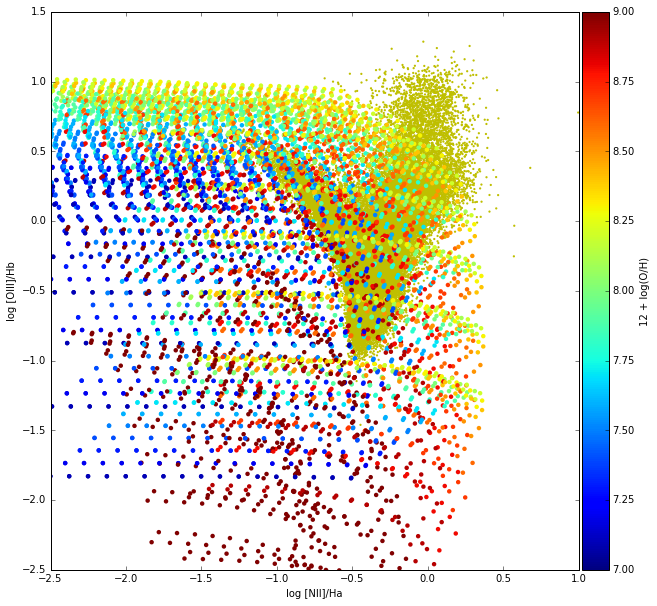

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, ax = plt.subplots(figsize=(10,10))

ax.scatter(obs['xN2Ha'], obs['yO3Hb'], edgecolor='none', color='y', 
           marker='.')
sc = ax.scatter(np.log10(res['N__2__6584A']/res['H__1__6563A']), 
           np.log10(res['O__3__5007A']/res['H__1__4861A']),
           c=12+res['oxygen'], edgecolor='none', vmin=7, vmax=9)
ax.set_xlabel('log [NII]/Ha')
ax.set_ylabel('log [OIII]/Hb')
ax.set_xlim((-2.5, 1))
ax.set_ylim((-2.5, 1.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = f.colorbar(sc, cax=cax)
cb.set_label('12 + log(O/H)')



### ??? Comments.

In [32]:
# the following is to have the nice style in the Notebook.
# Don't remove this.
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()